# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

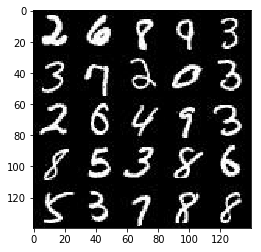

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

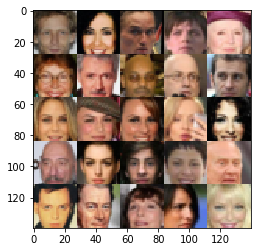

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data, learning_rate placeholder)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels])
    z_input_ = tf.placeholder(dtype=tf.float32, shape=[None, z_dim])
    lr_ = tf.placeholder(dtype=tf.float32, shape=None)
    
    return input_, z_input_, lr_


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [69]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.maximum(conv1, conv1 * alpha)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2, conv2 * alpha)

#         conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
#         conv3 = tf.layers.batch_normalization(conv3, training=not reuse)
#         conv3 = tf.maximum(conv3, conv3 * alpha)
        
        flat = tf.reshape(conv2,  shape=[-1,128*7*7])
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        #logits = tf.layers.dropout(logits, 0.5)
        output = tf.nn.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        layer0 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer0 = tf.reshape(layer0, [-1, 7, 7, 512])
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = tf.maximum(layer0, alpha*layer0)
        
        conv1 = tf.layers.conv2d_transpose(layer0, 256, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(conv1, conv1 * alpha)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(conv2, conv2 * alpha)

        conv3 = tf.layers.conv2d_transpose(conv2, out_channel_dim, 1, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        output = tf.nn.tanh(conv3)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [71]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
   
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [72]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    tf_vars = tf.trainable_variables()
    
    d_vars = [var for var in tf_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in tf_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [73]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [74]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 1 if data_image_mode == "L" else 3
    input_real, input_z, lr_ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train, g_train = model_opt(d_loss, g_loss, lr_, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                batch_images = batch_images*2 - 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _, _ = sess.run([d_train, g_train], feed_dict={input_real:batch_images, input_z:batch_z, lr_:learning_rate})
                if step % 50 == 0:
                    d_loss_var, g_loss_var = sess.run([d_loss, g_loss], feed_dict={input_real:batch_images, input_z:batch_z})
                    print("Epoch {}: Step:{} d_loss:{} g_loss:{}".format(epoch_i, step, d_loss_var, g_loss_var))
            show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
            #print("Epoch Finished with Generator Loss at {} and D Loss at {}".format())
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0: Step:0 d_loss:2.968844413757324 g_loss:0.5576919317245483
Epoch 0: Step:50 d_loss:0.3900905251502991 g_loss:3.3645708560943604
Epoch 0: Step:100 d_loss:0.3331206142902374 g_loss:9.883174896240234
Epoch 0: Step:150 d_loss:0.48192742466926575 g_loss:7.088865280151367
Epoch 0: Step:200 d_loss:0.3300328254699707 g_loss:7.660452842712402
Epoch 0: Step:250 d_loss:0.332613080739975 g_loss:7.898266792297363
Epoch 0: Step:300 d_loss:1.309890866279602 g_loss:3.7630882263183594
Epoch 0: Step:350 d_loss:0.5035108327865601 g_loss:15.108023643493652
Epoch 0: Step:400 d_loss:0.3309135437011719 g_loss:7.715917587280273
Epoch 0: Step:450 d_loss:0.3268161416053772 g_loss:8.03494930267334
Epoch 0: Step:500 d_loss:0.3274592459201813 g_loss:8.233299255371094
Epoch 0: Step:550 d_loss:0.3516479432582855 g_loss:8.451047897338867
Epoch 0: Step:600 d_loss:0.3263440728187561 g_loss:8.291949272155762
Epoch 0: Step:650 d_loss:0.35247373580932617 g_loss:8.38946533203125
Epoch 0: Step:700 d_loss:0.340223252

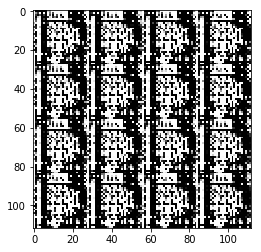

Epoch 1: Step:0 d_loss:0.332781046628952 g_loss:7.798378944396973
Epoch 1: Step:50 d_loss:0.32759207487106323 g_loss:7.984457492828369
Epoch 1: Step:100 d_loss:0.3386705815792084 g_loss:7.781567573547363
Epoch 1: Step:150 d_loss:0.34256836771965027 g_loss:7.627427577972412
Epoch 1: Step:200 d_loss:0.3262234330177307 g_loss:8.008370399475098
Epoch 1: Step:250 d_loss:0.3293978273868561 g_loss:8.418535232543945
Epoch 1: Step:300 d_loss:0.3304802477359772 g_loss:8.371464729309082
Epoch 1: Step:350 d_loss:0.32781919836997986 g_loss:8.223584175109863
Epoch 1: Step:400 d_loss:0.32927271723747253 g_loss:8.009072303771973
Epoch 1: Step:450 d_loss:0.3334794044494629 g_loss:7.979332447052002
Epoch 1: Step:500 d_loss:0.33410313725471497 g_loss:7.430687427520752
Epoch 1: Step:550 d_loss:0.3258935809135437 g_loss:7.585903167724609
Epoch 1: Step:600 d_loss:0.3293761909008026 g_loss:7.685542583465576
Epoch 1: Step:650 d_loss:0.3293375074863434 g_loss:7.343213081359863
Epoch 1: Step:700 d_loss:0.326896

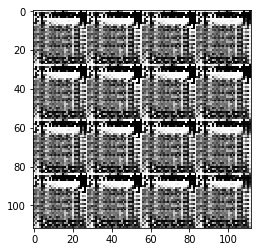

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 0: Step:0 d_loss:1.7982053756713867 g_loss:0.5664209127426147
Epoch 0: Step:50 d_loss:0.3463413119316101 g_loss:5.061385154724121
Epoch 0: Step:100 d_loss:0.33084896206855774 g_loss:6.558412551879883
Epoch 0: Step:150 d_loss:0.33792856335639954 g_loss:10.19233512878418
Epoch 0: Step:200 d_loss:0.6073235273361206 g_loss:19.094928741455078
Epoch 0: Step:250 d_loss:0.3268393278121948 g_loss:7.038211822509766
Epoch 0: Step:300 d_loss:0.3275144100189209 g_loss:7.395112037658691
Epoch 0: Step:350 d_loss:0.32901912927627563 g_loss:7.603370189666748
Epoch 0: Step:400 d_loss:0.3259044289588928 g_loss:8.146807670593262
Epoch 0: Step:450 d_loss:0.35493603348731995 g_loss:6.535679340362549
Epoch 0: Step:500 d_loss:0.3275095224380493 g_loss:7.9924540519714355
Epoch 0: Step:550 d_loss:0.33186835050582886 g_loss:7.702163219451904
Epoch 0: Step:600 d_loss:0.34588760137557983 g_loss:6.957198619842529
Epoch 0: Step:650 d_loss:0.34027373790740967 g_loss:6.912965774536133
Epoch 0: Step:700 d_loss:0.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.